### Tata Consumer products stock price forecast

#### Problem Statement
What will be the stock price of Tata consumer products stock after some time? 

For this, I am going to do time series forecast using ARIMA(AutoRegressive Integrated Moving Average) approach.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install pmdarima

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [ ]:
# Read stock price csv file and parsing dates
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/Tata_consumer/Tata_consumer_product.csv',parse_dates=['Date'])
df.head()

,Date,Close
0,2019-08-02 15:30:00,265.60
1,2019-08-05 15:30:00,260.90
2,2019-08-06 15:30:00,270.55
3,2019-08-07 15:30:00,269.40
4,2019-08-08 15:30:00,270.90


In [ ]:
# Removing the time from Date column and making it as index
df['Date'] = df['Date'].apply(lambda x: x.date())
df.set_index('Date',inplace=True)
df.index=pd.to_datetime(df.index)
df.head()

,Close
Date,
2019-08-02,265.60
2019-08-05,260.90
2019-08-06,270.55
2019-08-07,269.40
2019-08-08,270.90


In [ ]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:
df.describe()

,Close
count,500.000000
mean,473.564800
std,157.557875
min,226.500000
25%,324.437500
50%,470.100000
75%,607.537500
max,781.350000


Text(0, 0.5, 'Price (in INR)')

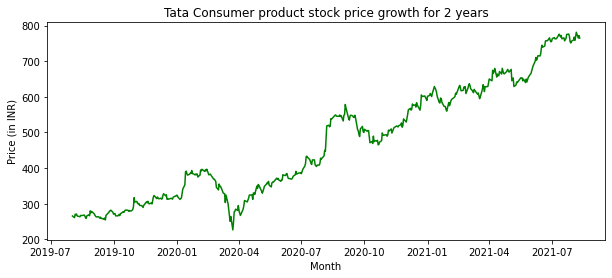

In [ ]:
# plotting the line graph of the stock price over the period of 2 months
plt.figure(figsize=(10, 4))
plt.plot(df.index,df.Close, color='green')
plt.title('Tata Consumer product stock price growth for 2 years')
plt.xlabel('Month')
plt.ylabel('Price (in INR)')

In [ ]:
# Check whether the data is stationary or not.
# A stationary time series is one where the statistical properties like mean, variance and autocorrelation is constant over time.
# A non stationary time series is one where the statistical properties change over time.

# for this, we can use adfuller test (Augumented Dickey Fuller Test)
# Null hypothesis - The data is not stationary
# Alternate hypothesis - The data is stationary

from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Close)
print(f'ADF Test Statistic : {result[0]}')
print(f'p-value : {result[1]}')
print(f'#Lags Used : {result[2]}')

ADF Test Statistic : -0.18541438234033794
p-value : 0.9402379995035913
#Lags Used : 7


Since the p-value is very much greater than 0.05(significance level) our null hypothesis is correct and our data is non stationary.

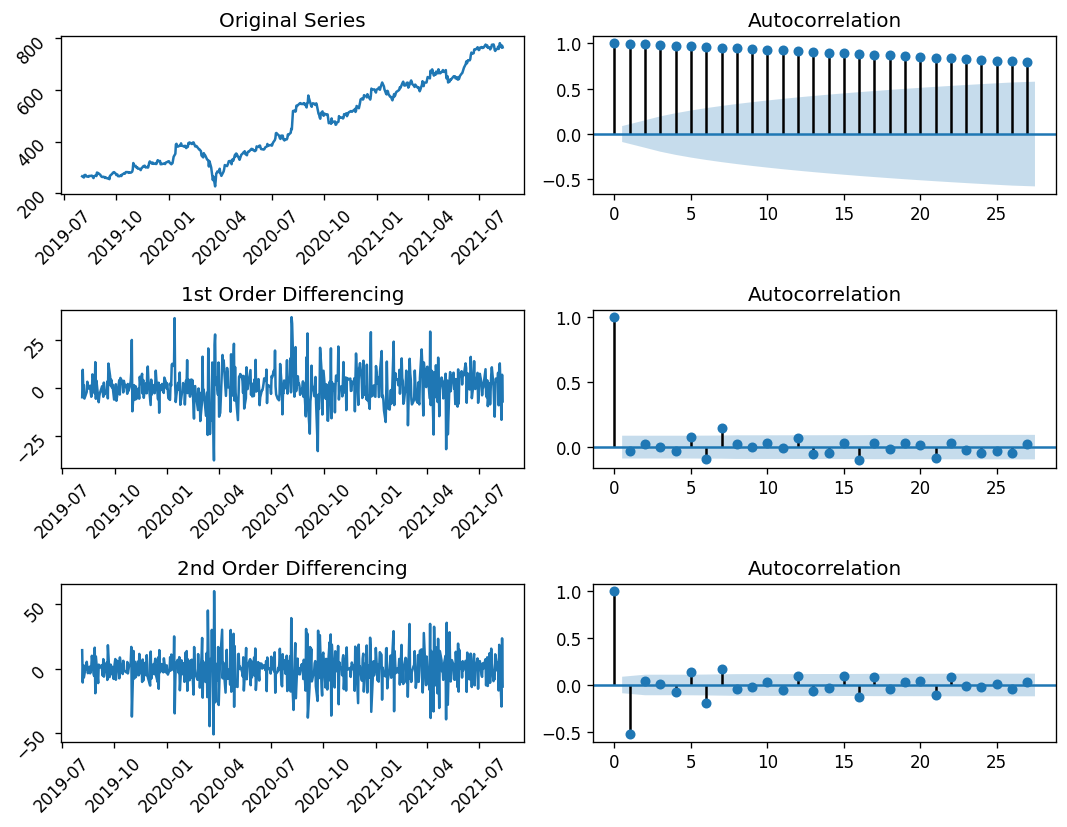

In [ ]:
# Plotting auto correlation to find the order of differencing (d)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2)

# original series
axes[0,0].plot(df.Close)
plot_acf(df['Close'],ax=axes[0,1])
axes[0,0].set_title('Original Series')
axes[0,0].tick_params(labelrotation=45)

# 1st Differencing
axes[1,0].plot(df.Close.diff())
plot_acf(df.Close.diff().dropna(), ax=axes[1, 1])
axes[1,0].set_title('1st Order Differencing')
axes[1,0].tick_params(labelrotation=45)

# 2nd Differencing
axes[2,0].plot(df.Close.diff().diff())
plot_acf(df.Close.diff().diff().dropna(), ax=axes[2, 1])
axes[2,0].set_title('2nd Order Differencing')
axes[2,0].tick_params(labelrotation=45)


fig.tight_layout()



From the above plots, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced. So the value of d could be 1.

In [ ]:
# checking the 1st order differnecing makes the data stationary or not.
result = adfuller(df.Close.diff().dropna())
print(f'ADF Test Statistic : {result[0]}')
print(f'p-value : {result[1]}')
print(f'#Lags Used : {result[2]}')

ADF Test Statistic : -7.44649290577409
p-value : 5.819799955516147e-11
#Lags Used : 6


From the above results, p-value of 1st order differencing data is very much smaller than the significance level 0.05. It shows our data is stationary after 1st oder of differencing and hence the value of d is 1.

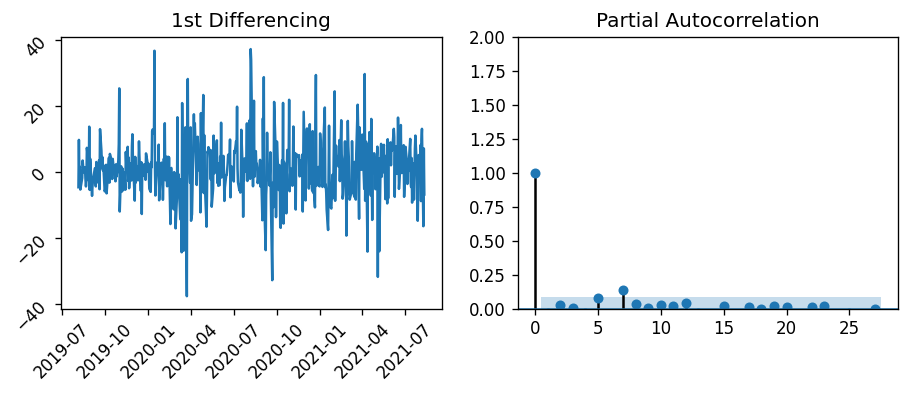

<Figure size 960x360 with 0 Axes>

In [ ]:
# PACF plot of 1st differenced series to find the order of AR terms (p)
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df.Close.diff())
axes[0].set_title('1st Differencing')
axes[0].tick_params(labelrotation=45)
axes[1].set(ylim=(0,2))
plot_pacf(df.Close.diff().dropna(), ax=axes[1])
plt.figure(figsize=(8,3))
plt.show()

The above partial autocorrelation plot shows there is no lags are above the significance line(blue region). So the value of p would be 0.

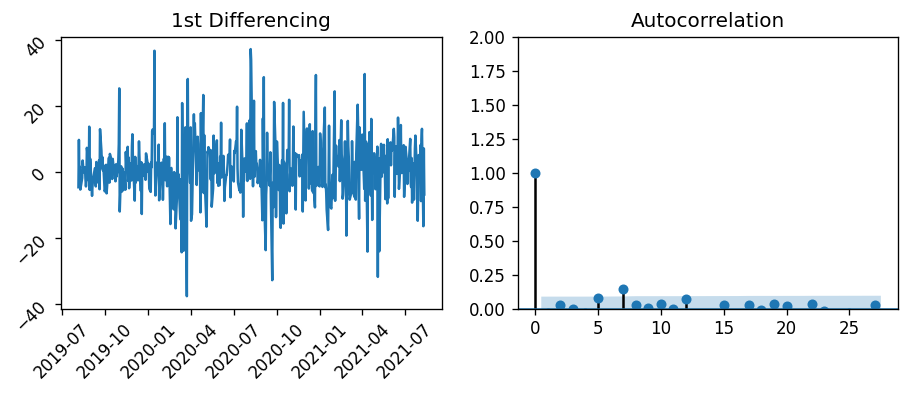

<Figure size 1200x600 with 0 Axes>

In [ ]:
# ACF plot of 1st differenced series to find the order of MA terms (q)
fig, axes = plt.subplots(1, 2)
axes[0].plot(df.Close.diff())
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,2))
axes[0].tick_params(labelrotation=45)
plot_acf(df.Close.diff().dropna(), ax=axes[1])
plt.figure(figsize=(10,5))
plt.show()

The above autocorrelation plot shows there is no lags are above the significance line(blue region). So the value of q would also be 0.

In [ ]:
# we have p = 0 , d = 1 and q = 0. Using this fitting ARIMA model

from statsmodels.tsa.arima_model import ARIMA

train_df = df.Close[:400]
test_df = df.Close[400:]



# 0,1,0 ARIMA Model
model = ARIMA(train_df, order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  399
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1455.654
Method:                           css   S.D. of innovations              9.294
Date:                Sat, 14 Aug 2021   AIC                           2915.307
Time:                        03:00:46   BIC                           2923.285
Sample:                             1   HQIC                          2918.467
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8648      0.465      1.859      0.063      -0.047       1.777


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

In [ ]:
# Trying auto ARIMA model to cross check our assumptions of p,d and q values are correct.

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

auto_model = pm.auto_arima(train_df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2918.849, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2915.307, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2917.256, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2917.259, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2916.747, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.886 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  400
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1455.654
Date:                Sat, 14 Aug 2021   AIC                           2915.307
Time:                        03:00:47   BIC                           2923.285
Sample:                             0   HQIC                          2918.467
                                - 400                                       

Based on the above results the Best model is ARIMA(0,1,0)(0,0,0)[0] which is same as our ARIMA model interpreted from the acf and pacf plots.

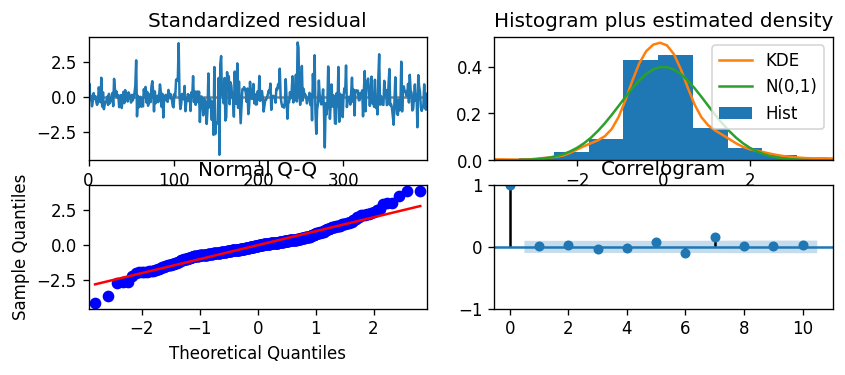

In [ ]:
# plot diagnostics to check the model
auto_model.plot_diagnostics(figsize=(8,3))
plt.show()

From the above diagnostics, top 2 plots showing the mean is fluctuating around mean 0 and normally distributed with uniform variance.

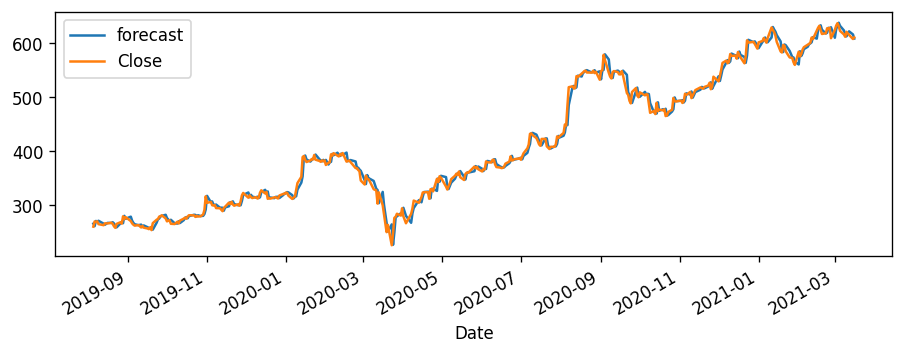

In [ ]:
# Plotting model prediction
model_fit.plot_predict(dynamic=False)
plt.show()

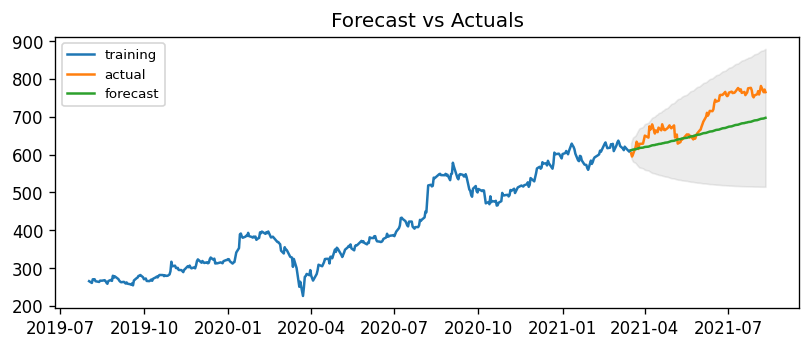

In [ ]:
# forecasting against actuals to find our model is best for use

fc, stderr, conf_int = model_fit.forecast(100)

forecast_series = pd.Series(fc, index=test_df.index)
lower_series = pd.Series(conf_int[:, 0], index=test_df.index)
upper_series = pd.Series(conf_int[:, 1], index=test_df.index)

# Plot
plt.figure(figsize=(8,3))
plt.plot(train_df, label='training')
plt.plot(test_df, label='actual')
plt.plot(forecast_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,color='grey',alpha=0.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# Calculating mean absolute percentage error
mape = np.mean(np.abs(fc - test_df)/np.abs(test_df))
print(mape)

0.06443235449270718


Mean absolute percentage error is around 6.4%. It shows our model is 94.6% accurate.

In [ ]:
# Forecasting future values by fitting all of the data.
# 0,1,0 ARIMA Model
model = ARIMA(df.Close, order=(0,1,0))
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

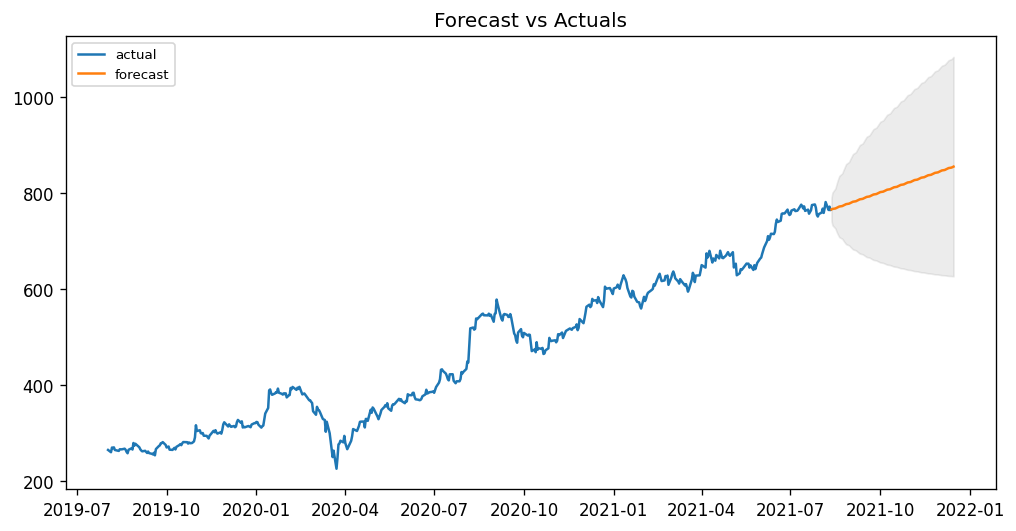

In [ ]:
# Get the future Business dates alone for 90 days.
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(days=x) for x in range(0,91)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_datest_df.index=pd.date_range(start='2021-08-12',periods=90,freq='B')


#future_datest_df.tail()
#future_df=pd.concat([df,future_datest_df])
#future_df.reset_index(drop=True,inplace=True)

# Forecasting future dates
forecast, stderr, conf_int = model_fit.forecast(90,alpha=0.01)

forecast_series = pd.Series(forecast, index=future_datest_df.index)
lower_series = pd.Series(conf_int[:, 0], index=future_datest_df.index)
upper_series = pd.Series(conf_int[:, 1], index=future_datest_df.index)

# Plot
plt.figure(figsize=(10,5))
plt.plot(df.Close, label='actual')
plt.plot(forecast_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,color='grey',alpha=0.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
future_datest_df['Close'] = forecast_series
future_datest_df['Conf_int_min'] = lower_series
future_datest_df['Conf_int_max'] = upper_series
future_datest_df.sample(5)

,Close,Conf_int_min,Conf_int_max
2021-11-11,831.052906,635.615422,1026.490390
2021-08-13,767.001603,732.980304,801.022902
2021-12-03,847.065731,629.223126,1064.908337
2021-12-02,846.064930,629.554708,1062.575152
2021-08-18,770.004008,716.211611,823.796405


In [ ]:
future_datest_df['2021-08']

,Close,Conf_int_min,Conf_int_max
2021-08-12,766.000802,741.944110,790.057493
2021-08-13,767.001603,732.980304,801.022902
2021-08-16,768.002405,726.334993,809.669816
2021-08-17,769.003206,720.889824,817.116589
2021-08-18,770.004008,716.211611,823.796405
2021-08-19,771.004810,712.078191,829.931428
2021-08-20,772.005611,708.357589,835.653634
2021-08-23,773.006413,704.963815,841.049011
2021-08-24,774.007214,701.837140,846.177288
2021-08-25,775.008016,698.934078,851.081954
